In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/home/kanai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_use_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
shift = 20

In [3]:
df = pd.read_csv("btcjpy_data_from_yfinance-5y-1d.csv",usecols=csv_use_cols)

In [4]:
df["diff_ratio"] = df["Close"].diff()/df["Close"] 
print(df["diff_ratio"].describe())

df["target"] = df["diff_ratio"].shift(-1)
df["target"] = df["target"]*1000

count    1826.000000
mean        0.000866
std         0.036812
min        -0.590086
25%        -0.013388
50%         0.000780
75%         0.016721
max         0.176391
Name: diff_ratio, dtype: float64


In [5]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA25"] = ta.EMA(df["Close"], timeperiod=25)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA100"] = ta.EMA(df["Close"], timeperiod=100)
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=14)

for i in range(0, shift+1):
    df["Open-{0}ratio".format(i)] = df["Open"].shift(i)/df["Close"]
    df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
    df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
    df["Close-{0}ratio".format(i)] = df["Close"].shift(i)/df["Close"]
    df["EMA5-{0}ratio".format(i)] = df["EMA5"].shift(i)/df["Close"]
    df["EMA25-{0}ratio".format(i)] = df["EMA25"].shift(i)/df["Close"]
    df["EMA50-{0}ratio".format(i)] = df["EMA50"].shift(i)/df["Close"]
    df["EMA100-{0}ratio".format(i)] = df["EMA100"].shift(i)/df["Close"]
    df["Volume-{0}".format(i)] = df["Volume"].shift(i)
    df["RSI-{0}".format(i)] = df["RSI"].shift(i)
    df["MFI-{0}".format(i)] = df["MFI"].shift(i)

df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_86241/308158195.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
/tmp/ipykernel_86241/308158195.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
/tmp/ipykernel_86241/308158195.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [6]:
df = df[df["target"] > -200]

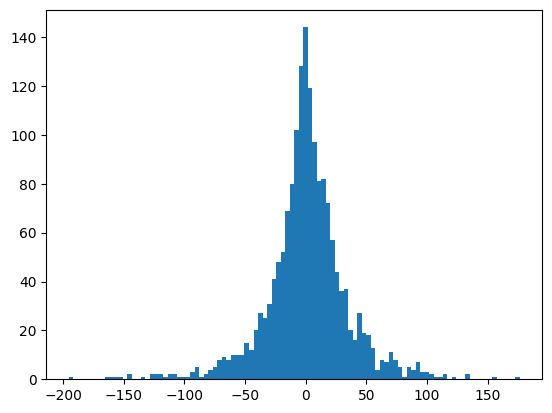

In [7]:
plt.hist(df["target"], bins=100)
plt.savefig("diff_ratio.png")
plt.show()

In [8]:
mlcols = []
for i in range(0, shift+1):
    mlcols.append("Open-{0}ratio".format(i))
    mlcols.append("High-{0}ratio".format(i))
    mlcols.append("Low-{0}ratio".format(i))
    mlcols.append("Close-{0}ratio".format(i))
    mlcols.append("EMA5-{0}ratio".format(i))
    mlcols.append("EMA25-{0}ratio".format(i))
    mlcols.append("EMA50-{0}ratio".format(i))
    mlcols.append("EMA100-{0}ratio".format(i))
    mlcols.append("Volume-{0}".format(i))
    mlcols.append("RSI-{0}".format(i))
    mlcols.append("MFI-{0}".format(i))

X = df[mlcols]
Y = df["target"]
print(X.describe())
print(X.info)
print(Y.describe())
print(Y.info)
xgbtraindata = xgb.DMatrix(data=X, label=Y)

       Open-0ratio  High-0ratio   Low-0ratio  Close-0ratio  EMA5-0ratio  \
count  1706.000000  1706.000000  1706.000000        1706.0  1706.000000   
mean      0.999392     1.020885     0.976542           1.0     0.998508   
std       0.037318     0.027951     0.024722           0.0     0.033098   
min       0.824706     0.991138     0.718463           1.0     0.881475   
25%       0.982981     1.005259     0.968701           1.0     0.981833   
50%       0.999321     1.011777     0.984217           1.0     0.997791   
75%       1.013897     1.026726     0.992806           1.0     1.012494   
max       1.590526     1.595017     1.010575           1.0     1.425853   

       EMA25-0ratio  EMA50-0ratio  EMA100-0ratio      Volume-0        RSI-0  \
count   1706.000000   1706.000000    1706.000000  1.706000e+03  1706.000000   
mean       0.991248      0.983276       0.968901  3.550206e+12    53.315390   
std        0.091387      0.132550       0.183684  1.977338e+12    13.968227   
min     

In [9]:
def objective(trial,df_X,df_y):
    params ={
        'max_depth':trial.suggest_int("max_depth",3,12),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_float('gamma',0,1),
        'subsample':trial.suggest_float('subsample',0,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_float('reg_alpha',1e-5,100,log=True),
        'reg_lambda':trial.suggest_float('reg_lambda',1e-5,100,log=True),        
        'learning_rate':trial.suggest_float('learning_rate',0,0.7)}
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, df_X, df_y, scoring='neg_mean_squared_error', cv=5)
    score_mean = -1*np.mean(scores)
    
    return score_mean

study = optuna.create_study()
study.optimize(lambda trial: objective(trial,X,Y), n_trials=10)

print(study.best_params)

[I 2024-01-28 20:40:24,288] A new study created in memory with name: no-name-7faede49-bbae-42a7-b917-a66f09c66a95
[I 2024-01-28 20:40:35,965] Trial 0 finished with value: 1702.0611842239846 and parameters: {'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.773149715259378, 'subsample': 0.8075159200537819, 'colsample_bytree': 0.996679823220503, 'reg_alpha': 0.0002720813418934956, 'reg_lambda': 0.004409863114258183, 'learning_rate': 0.3292649434804317}. Best is trial 0 with value: 1702.0611842239846.
[I 2024-01-28 20:40:40,777] Trial 1 finished with value: 1343.2356134748873 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.9900932912081364, 'subsample': 0.9219325413812212, 'colsample_bytree': 0.23052381142552514, 'reg_alpha': 0.12851014337657768, 'reg_lambda': 5.3300216606808554e-05, 'learning_rate': 0.08724514595296706}. Best is trial 1 with value: 1343.2356134748873.
[I 2024-01-28 20:40:46,118] Trial 2 finished with value: 1544.7004011944016 and parameters: {'max_dep

{'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.2982011385779879, 'subsample': 0.6204851491278763, 'colsample_bytree': 0.3466386625620749, 'reg_alpha': 22.0081509395518, 'reg_lambda': 7.12444439236023, 'learning_rate': 0.07773292744154515}


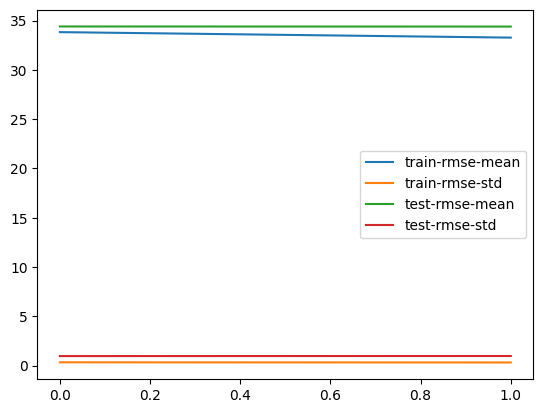

In [10]:
params = study.best_params
dd = xgb.cv(params, xgbtraindata, num_boost_round=10000, early_stopping_rounds=100, nfold=4, metrics='rmse', seed=0)
plt.plot(dd)
plt.legend(dd.columns)
plt.savefig("cv.png")
plt.show()

MSE
579.0840427414226


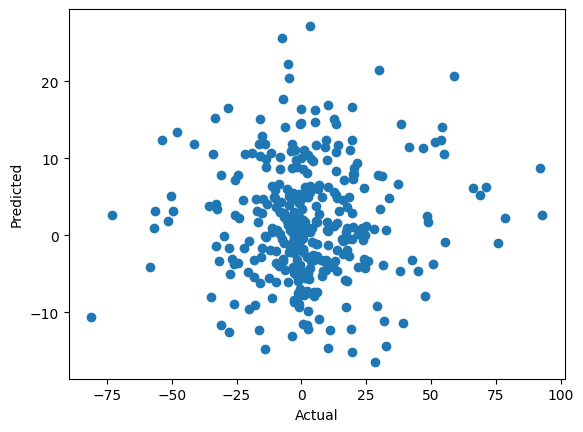

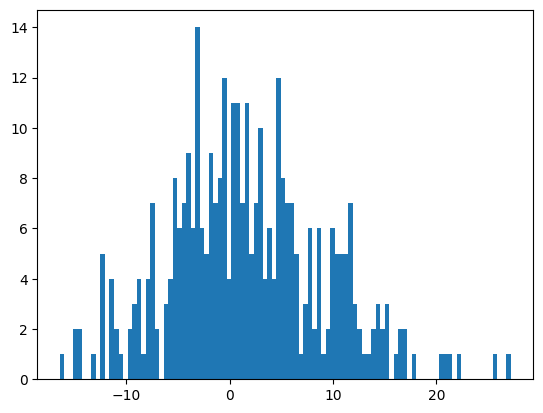

<Figure size 5000x5000 with 0 Axes>

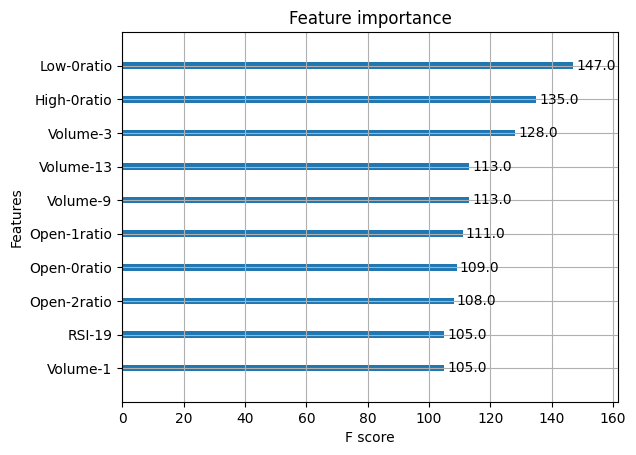

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = XGBRegressor(objective='reg:squarederror', **params)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("MSE")
print(mean_squared_error(Y_test, Y_pred))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("prediction.png")
plt.show()

plt.hist(Y_pred, bins=100)
plt.show()

fig = plt.figure(figsize=(100,100),dpi=50)
plot_importance(model, max_num_features=10)
plt.savefig("feature_importance.png")
plt.rcParams["figure.figsize"] = [100,100]
plt.show()